In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import datasets
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import linear_model 
from sklearn.metrics import mean_squared_error, r2_score


In [35]:
dfbcn = pd.read_csv('Dataset/sale_Barcelona.csv', delimiter = ',')

In [36]:
# Vemos donde hay valores nulos
print(dfbcn.isnull().sum())

id                         0
price                      0
currency                   0
latitude                   0
longitude                  0
sq_meters               2573
sq_meters_built            0
rooms                      0
bathrooms                  0
balcony                 3637
terrace                 4419
exterior                1077
orientation             2713
floor                   2082
rooftop                 5440
elevator                 571
doorman                 5847
pool                    5677
ac                      3198
heating                 2490
year_built              1765
quality                    0
city                       0
neighborhood               0
dist_city_center           0
furniture               5847
garage                  5442
property_type              2
garden                  5786
closest_station            0
dist_closest_station       0
created_at                 0
last_seen                  0
dtype: int64


In [37]:
# Aplicamos la misma solucion que en el eda para los nans
dfbcn['sq_meters'].fillna(dfbcn['sq_meters'].mean(), inplace=True)
dfbcn['floor'].fillna(dfbcn['floor'].median(), inplace=True)

vars_missing = ['exterior','elevator']
dfbcn[vars_missing] = dfbcn[vars_missing].fillna(0)


dfbcn[vars_missing] = dfbcn[vars_missing].applymap(lambda x: 1 if x != 0 else 0)

# Seleccionamos solo columnas numéricas relevantes para estimar 'year_built'
cols_for_imputation = ['price', 'sq_meters_built', 'rooms', 'bathrooms', 'quality', 'year_built']
impute_df = dfbcn[cols_for_imputation].copy()

# Normalizamos las columnas
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(impute_df)

# Aplicamos KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(scaled_data)

# Deshacemos la normalización solo para 'year_built'
imputed_df = pd.DataFrame(scaler.inverse_transform(imputed_data), columns=cols_for_imputation)

# Reemplazamos los valores en dfbcn
dfbcn['year_built'] = imputed_df['year_built'].round().astype(int)

In [38]:
#Convertimos el precio a escala logaritmica
dfbcn['price'] = np.log(dfbcn['price'])

C:\Users\heatb\AppData\Local\Temp\ipykernel_14612\2943176033.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dfbcn.corr()


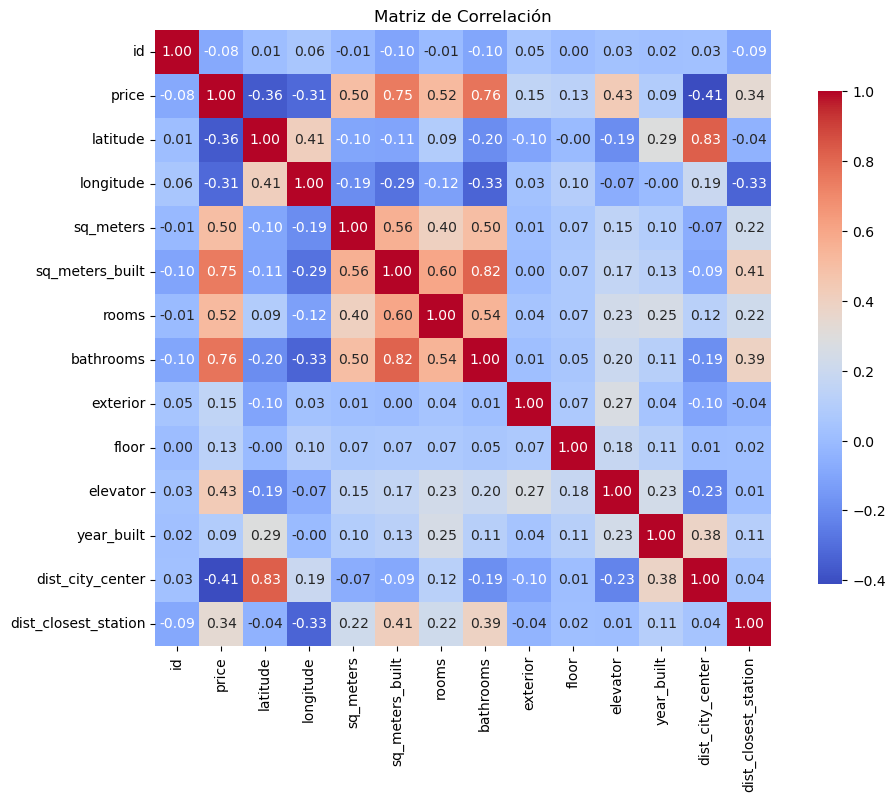

In [39]:
# Ahora creamos una matriz de correlación para ver la relación entre las variables
# Las variables balcony, terrace, doorman, pool, ac, quality, furniture, garage y garden se eliminan para la matriz de correlación
columns_to_drop = ['balcony', 'terrace', 'doorman', 'pool', 'ac', 'quality', 'furniture', 'garage', 'garden', 'rooftop']
existing_columns_to_drop = [col for col in columns_to_drop if col in dfbcn.columns]
dfbcn = dfbcn.drop(columns=existing_columns_to_drop)
correlation_matrix = dfbcn.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación')
plt.show()

In [40]:
X = dfbcn[['sq_meters', 'sq_meters_built', 'rooms', 'bathrooms',
           'exterior', 'floor', 'elevator', 'year_built',
           'dist_city_center', 'dist_closest_station']]

# Verifica si hay NaNs o infinitos
print(X.isnull().sum())             # NaNs
print(np.isinf(X).sum())            # Infinitos (requiere import numpy as np)


sq_meters               0
sq_meters_built         0
rooms                   0
bathrooms               0
exterior                0
floor                   0
elevator                0
year_built              0
dist_city_center        0
dist_closest_station    0
dtype: int64
sq_meters               0
sq_meters_built         0
rooms                   0
bathrooms               0
exterior                0
floor                   0
elevator                0
year_built              0
dist_city_center        0
dist_closest_station    0
dtype: int64


In [41]:
# Definimos las variables independientes (X) y la dependiente (y)
X = dfbcn[['sq_meters', 'sq_meters_built', 'rooms', 'bathrooms',
           'exterior', 'floor', 'elevator', 'year_built',
           'dist_city_center', 'dist_closest_station']]
y = np.log(dfbcn['price'])

# Agregamos constante para el intercepto
X = sm.add_constant(X)

# Creamos el modelo
model = sm.OLS(y, X)

# Ajustamos el modelo
results = model.fit()

# Mostramos el resumen
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     2129.
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        13:56:39   Log-Likelihood:                 12351.
No. Observations:                5847   AIC:                        -2.468e+04
Df Residuals:                    5836   BIC:                        -2.461e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.2400 

Al haber muchas variables correlacionadas entre sí, nos indica de alta multicolinealidad. No solamente el r2 es alto, sino que también la Inflación de la Varianza, que es otro factor que determina esta multicolinealidad. Esto hace que el coeficiente de cada variable tenga poca interpretabilidad estadística y econímica. Concluimos entonces que no podemos estimar estos coeficientes y la imposibilidad de estimar el modelo.

In [42]:
# Vamos a dividir los datos en conjuntos de entrenamiento y prueba 90 / 10 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# Verificar la forma de los conjuntos de entrenamiento y prueba
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (5262, 11)
X_test shape: (585, 11)
y_train shape: (5262,)
y_test shape: (585,)


In [43]:
# Iniciamos y ajustamos un modelo de regresion lineal simple
lr = LinearRegression() 
lr.fit(X_train, y_train) # Entrenar el modelo

# Buscamos los coeficientes del modelo
coefs_lr = pd.Series(np.abs(lr.coef_)).sort_values(ascending=False)

# Realizamos predicciones sobre los valores de prueba
y_test_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train) # Predicciones sobre el conjunto de entrenamiento

mse_train = mean_squared_error(y_train, y_train_pred) # Error cuadrático medio para el conjunto de entrenamiento
mse_test = mean_squared_error(y_test, y_test_pred) # Error cuadrático medio para el conjunto de prueba

r2_score_train = lr.score(X_train, y_train) # R^2 para el conjunto de entrenamiento
r2_score_test = lr.score(X_test, y_test) # R^2 para el conjunto de prueba

# Mostrar el intercepto y los coeficientes
print("Intercepto y coeficientes del modelo: \n \n Intercepto: {} \nCoeficientes: {} \n".format(lr.intercept_, coefs_lr))

# Mostrar el error cuadrático medio y R^2
print("Error cuadrático medio (MSE) para el conjunto de entrenamiento: ", mse_train)
print("Error cuadrático medio (MSE) para el conjunto de prueba: ", mse_test)
print("R^2 para el conjunto de entrenamiento: ", r2_score_train)
print("R^2 para el conjunto de prueba: ", r2_score_test)


Intercepto y coeficientes del modelo: 
 
 Intercepto: 2.2377611386797818 
Coeficientes: 7     0.024406
4     0.020741
10    0.014773
9     0.010274
5     0.008427
3     0.006695
6     0.001442
2     0.000297
8     0.000105
1     0.000076
0     0.000000
dtype: float64 

Error cuadrático medio (MSE) para el conjunto de entrenamiento:  0.0008390767346669477
Error cuadrático medio (MSE) para el conjunto de prueba:  0.0010218885985433272
R^2 para el conjunto de entrenamiento:  0.7865926239835579
R^2 para el conjunto de prueba:  0.7682286231692333


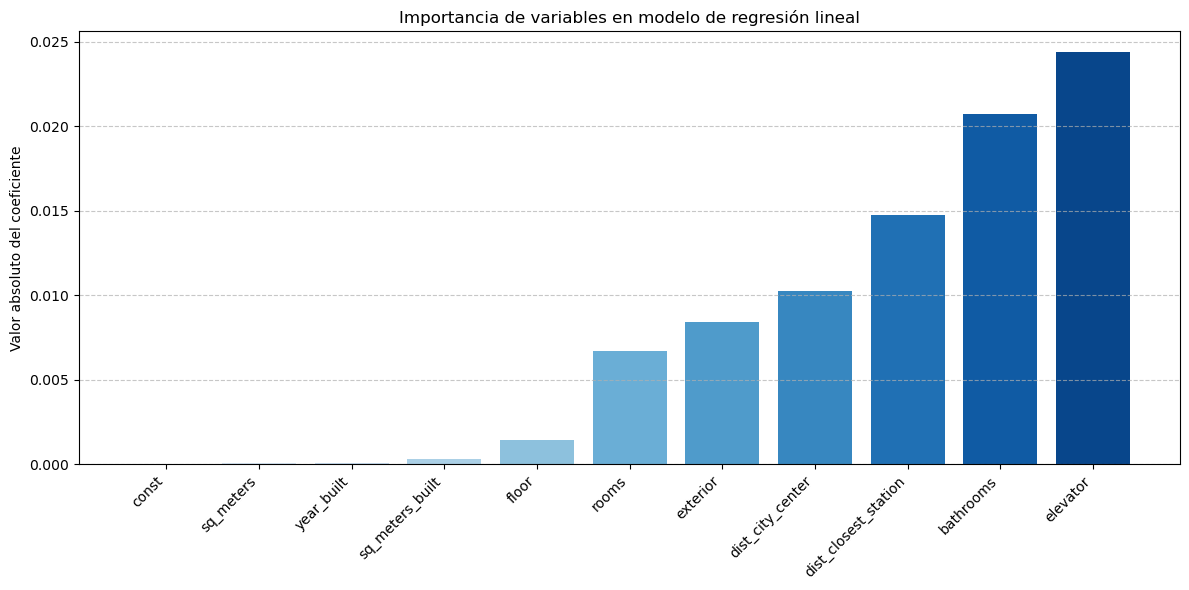

In [44]:
# Crear Series con coeficientes absolutos y nombres de variables
coefs_abs = pd.Series(np.abs(lr.coef_), index=X_train.columns)
coefs_abs_sorted = coefs_abs.sort_values(ascending=True)

# Colores según la magnitud (más oscuro = mayor impacto)
colors = sns.color_palette("Blues", len(coefs_abs_sorted))

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(coefs_abs_sorted.index, coefs_abs_sorted.values, color=colors)

# Etiquetas
plt.xticks(rotation=45, ha='right')
plt.ylabel("Valor absoluto del coeficiente")
plt.title("Importancia de variables en modelo de regresión lineal")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Claramente el sobreajuste del modelo y la multicolinealidad que tenemos nos está arrojando unas relaciones espurias con unos resultados con poca lógica. Uno esperaria que el factor mas importante a determinar el precio serían los metros cuadrados o el numero de habitaciones, sin embargo usando la regresión linal y el MCO, nos da que el coeficiente que más peso tiene sobre la variable objetivo es si tiene ascensor o el numero de baños.

Vamos entonces a utilizar Ridge y Lasso, que son modelos de regresión más robsutos y que penalizan a multicolinealidad junto con aquellos errores cuadráticos medios elevados, normalizandolos (sin acabar de reducir a 0), entonces ahí vamos a utilizar estas dos técnicas para ver que resultados podemos obtener.

In [45]:
# Lista de alphas a evaluar (puedes refinarla si ya tienes una idea de magnitudes)
alphas = np.logspace(-3, 5, 100)

# Creamos un pipeline que escala y ajusta Ridge con CV
ridge_cv = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=alphas, store_cv_values=True)
)

# Ajustamos a los datos de entrenamiento
ridge_cv.fit(X_train, y_train)

# Obtenemos el mejor alpha encontrado
best_alpha = ridge_cv.named_steps['ridgecv'].alpha_
print(f"Mejor alpha encontrado por RidgeCV: {best_alpha}")

Mejor alpha encontrado por RidgeCV: 123.28467394420684


In [46]:
# Escalado previo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Definir el modelo y la búsqueda
ridge = Ridge()
param_grid = {'alpha': np.logspace(-3, 5, 100)}

grid = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train_scaled, y_train)

print(f"Mejor alpha: {grid.best_params_['alpha']}")

Mejor alpha: 84.97534359086455


In [52]:
# Escalar X_train y X_test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = Ridge(alpha=104) # Inicializamos el regresor Ridge con una alpha encontrada de 104
ridge.fit(X_train_scaled, y_train) # Ajustamos el modelo a los datos de entrenamiento

# Extraemos los coeficientes y los ordenamos en función de su valor absoluto
coefs_ridge = pd.Series(np.abs(ridge.coef_), index=X_train.columns).sort_values(ascending=False)

# Realizamos la predicción en el conjunto de prueba y entrenamiento
y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

c:\Users\heatb\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\heatb\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [54]:
# Coeficientes absolutos de Ridge
ridge_coefs = pd.Series(np.abs(ridge.coef_), index=X_train.columns).sort_values()

# Evaluación del modelo: calculamos el Error Cuadrático Medio (MSE) y el R^2
mse_ridge_train = mean_squared_error(y_train, y_train_pred_ridge) # MSE en entrenamiento
mse_ridge_test = mean_squared_error(y_test, y_test_pred_ridge) # MSE en prueba
r2score_ridge_train = ridge.score(X_train, y_train) # R^2 en entrenamiento
r2score_ridge_test = ridge.score(X_test, y_test) # R^2 en prueba

c:\Users\heatb\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\heatb\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [55]:
# Mostramos los resultados:
print('\nIntercepto del modelo:', ridge.intercept_)
print('\nCoeficientes del modelo Ridge:\n', ridge.coef_)
print('\nError Cuadrático Medio (MSE) en entrenamiento:', mse_ridge_train)
print('Error Cuadrático Medio (MSE) en prueba:', mse_ridge_test)
print('\nPuntaje R^2 en entrenamiento:', r2score_ridge_train)
print('Puntaje R^2 en prueba:', r2score_ridge_test)


Intercepto del modelo: 2.515320823813266

Coeficientes del modelo Ridge:
 [ 0.          0.00310059  0.01932919  0.0078019   0.01668739  0.00381154
  0.00274263  0.01202871  0.00330146 -0.02031892  0.00425349]

Error Cuadrático Medio (MSE) en entrenamiento: 71.3141643311837
Error Cuadrático Medio (MSE) en prueba: 72.89384292711135

Puntaje R^2 en entrenamiento: -18136.755528121135
Puntaje R^2 en prueba: -16531.825947745336


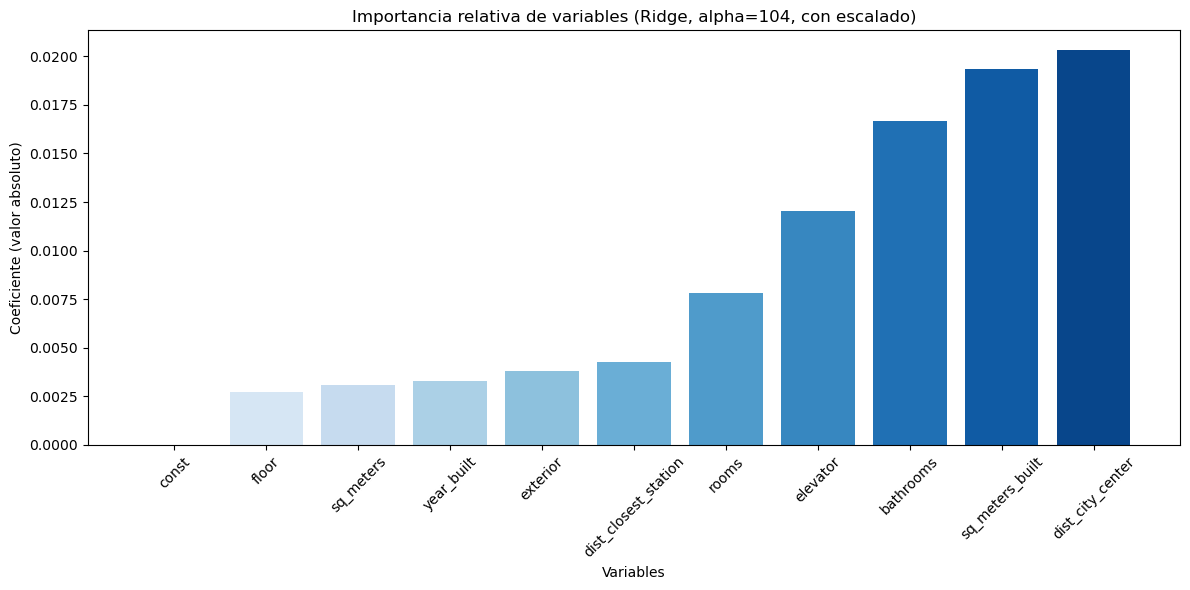

In [57]:
# Colores según la magnitud (más oscuro = mayor impacto)
colors2 = sns.color_palette("Blues", len(ridge_coefs))

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(ridge_coefs.index, ridge_coefs.values, color=colors2)


# Graficamos
plt.xticks(rotation=45)
plt.title("Importancia relativa de variables (Ridge, alpha=104, con escalado)")
plt.ylabel("Coeficiente (valor absoluto)")
plt.xlabel("Variables")
plt.tight_layout()
plt.show()


In [88]:
# Escalado + LassoCV para encontrar alpha óptimo
alphas = np.logspace(-4, 1, 100)  # valores de alpha a probar (de 0.0001 a 10)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)

In [89]:
# Pipeline para escalar y ajustar LassoCV
pipeline = make_pipeline(StandardScaler(), lasso_cv)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv',
                 LassoCV(alphas=array([1.00000000e-04, 1.12332403e-04, 1.26185688e-04, 1.41747416e-04,
       1.59228279e-04, 1.78864953e-04, 2.00923300e-04, 2.25701972e-04,
       2.53536449e-04, 2.84803587e-04, 3.19926714e-04, 3.59381366e-04,
       4.03701726e-04, 4.53487851e-04, 5.09413801e-04, 5.72236766e-04,
       6.42807312e-04, 7.22080902...
       6.89261210e-01, 7.74263683e-01, 8.69749003e-01, 9.77009957e-01,
       1.09749877e+00, 1.23284674e+00, 1.38488637e+00, 1.55567614e+00,
       1.74752840e+00, 1.96304065e+00, 2.20513074e+00, 2.47707636e+00,
       2.78255940e+00, 3.12571585e+00, 3.51119173e+00, 3.94420606e+00,
       4.43062146e+00, 4.97702356e+00, 5.59081018e+00, 6.28029144e+00,
       7.05480231e+00, 7.92482898e+00, 8.90215085e+00, 1.00000000e+01]),
                         cv=5, random_state=42))])

In [90]:
# Mejor alpha encontrado
best_alpha = lasso_cv.alpha_
print("Alpha óptimo:", best_alpha)

Alpha óptimo: 0.0001


In [91]:
# Entrenamos el modelo Lasso con el alpha óptimo encontrado
lasso = Lasso(alpha=best_alpha)
lasso.fit(StandardScaler().fit_transform(X_train), y_train)  # Escalamos X_train para ajustar el modelo

Lasso(alpha=0.0001)

In [104]:
# Convertimos los coeficientes a valor absoluto y los ordenamos
coefs_lasso_abs = pd.Series(np.abs(lasso.coef_), index=X_train.columns).sort_values()

print("\nCoeficientes del modelo Lasso:")
print(coefs_lasso_abs)


Coeficientes del modelo Lasso:
const                   0.000000
exterior                0.000000
dist_closest_station    0.000000
sq_meters               0.000103
year_built              0.000185
sq_meters_built         0.000456
floor                   0.001099
rooms                   0.004591
bathrooms               0.008955
dist_city_center        0.010976
elevator                0.013500
dtype: float64


In [102]:
# Encontrar el mejor alpha
lasso_cv = LassoCV(cv=5).fit(X_train, y_train)
best_alpha = lasso_cv.alpha_

# Ajustar Lasso con el mejor alpha
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)

# Crear gráfico correctamente
coefs_lasso_abs = pd.Series(np.abs(lasso.coef_), index=X_train.columns).sort_values()

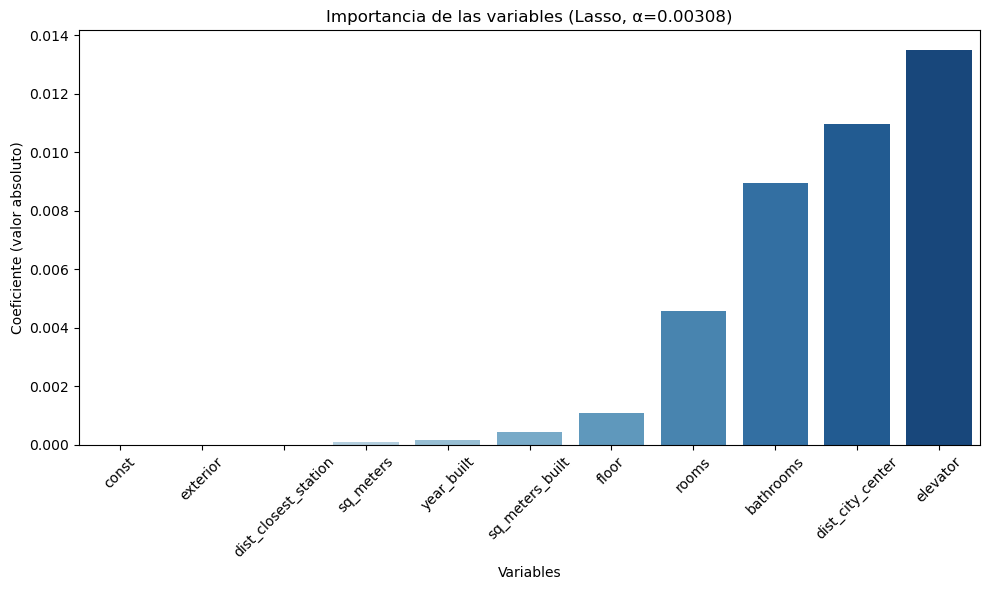

In [103]:
# Definimos la paleta de colores "Blues"
colors3 = sns.color_palette("Blues", len(coefs_lasso_abs))

# Creamos el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=coefs_lasso_abs.index, y=coefs_lasso_abs.values, palette=colors3)

# Ajustes estéticos
plt.xticks(rotation=45)
plt.title(f"Importancia de las variables (Lasso, α={round(best_alpha, 5)})")
plt.ylabel("Coeficiente (valor absoluto)")
plt.xlabel("Variables")
plt.tight_layout()
plt.show()